## 1. Importing Libraries and Data

In [216]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pickle

import nltk
from nltk.corpus import wordnet
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import sklearn
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, GlobalAveragePooling1D, MaxPooling1D, Conv1D, Embedding, Flatten
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [3]:
df_fake = pd.read_csv('data/Fake.csv.gz')

In [4]:
df_fake['fake'] = 1

In [12]:
len(df_fake)

23481

In [5]:
df_true = pd.read_csv('data/True.csv.gz')

In [6]:
df_true['fake'] = 0

In [13]:
len(df_true)

21417

Adding the binary 1/0 labels for fake/real news articles.

In [14]:
df_true_upsampled = resample(df_true, replace=True, n_samples=len(df_fake), random_state=42)

In [15]:
df = pd.concat([df_fake, df_true_upsampled], axis=0)

In [16]:
df = sklearn.utils.shuffle(df, random_state=42).reset_index(drop=True)

Upsampling the real news articles to counter the slight class imbalance that was present. The fake and real news dataframes were then concatenated and shuffled to get an even distribution of the classes throughout the dataframe.

In [17]:
len(df)

46962

In [21]:
df['fake'].value_counts(normalize=True)

1    0.5
0    0.5
Name: fake, dtype: float64

In [24]:
df.drop(columns=['text', 'subject', 'date'], inplace=True)
df.rename(columns={'title':'headline'}, inplace=True)

In [ ]:
df.isnull().sum()

In [25]:
df.to_csv('data/data_cleaned.csv')

We are only interested in predicting the validity of the news article from the headline alone, therefore I remove the 'text', 'subject' and 'date' columns. This dataframe is then saved as a csv to be loaded in for a later section.

In [27]:
df.head()

,headline,fake
0,NOT KIDDING! OBAMA Agrees To Turkey’s Demands…...,1
1,"Clinton, in book, says Trump's debate stalking...",0
2,BREAKING NEWS: Susan Rice ADMITS To Unmasking ...,1
3,China's interference in Hong Kong reaching ala...,0
4,WOW! FOX REPORTER GOES OFF On SEIU Thug For Te...,1


## 2. Preprocessing with NLTK

For the random forest model, NLP preprocessing is done with NLTK. This includes the following stages:

- Removing punctuation
- Tokenization
- Removing stop words
- Part of speech tagging
- Lemmatization
- Word vectorization
- TFIDF transformation

In [28]:
df['headline'] = df['headline'].apply(lambda x: re.sub(r"\<.*\>", "", x))

In [29]:
punctuation = '''!()-[]{};:"\,<>./?@#$%^&*_~'''

In [30]:
def remove_punctuation(review):
    cleaned = "".join([char for char in review if char not in punctuation])
    return cleaned

In [31]:
df['headline'] = df['headline'].apply(lambda x: remove_punctuation(x))

In [32]:
df.head()

,headline,fake
0,NOT KIDDING OBAMA Agrees To Turkey’s Demands…U...,1
1,Clinton in book says Trump's debate stalking m...,0
2,BREAKING NEWS Susan Rice ADMITS To Unmasking “...,1
3,China's interference in Hong Kong reaching ala...,0
4,WOW FOX REPORTER GOES OFF On SEIU Thug For Tel...,1


In [33]:
df = df.loc[df['headline'] != '']

In [34]:
lemmatizer = WordNetLemmatizer()

In [35]:
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

In [36]:
def remove_stopwords(review_tokenized):
    no_stop = [word.lower() for word in review_tokenized if word.lower() not in stop_words]
    return no_stop

In [37]:
def lemmatize_review(review):
    tokenized = nltk.word_tokenize(review)
    no_stop = remove_stopwords(tokenized)
    nltk_tagged = nltk.pos_tag(no_stop)  
    wn_tagged = map(lambda x: (x[0], get_wordnet_pos(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wn_tagged:
        if tag is None:
            lemmatized_sentence.append(word)
        else:        
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)

In [38]:
stop_words = stopwords.words("English")

In [39]:
df['headline'] = df['headline'].apply(lambda x: lemmatize_review(x))

In [40]:
df.head()

,headline,fake
0,kid obama agree turkey ’ demands…us troop orde...,1
1,clinton book say trump 's debate stalking make...,0
2,break news susan rice admits unmask “ us perso...,1
3,china 's interference hong kong reach alarm le...,0
4,wow fox reporter go seiu thug tell black prote...,1


In [41]:
vectorizer = CountVectorizer(max_features=1000, min_df=5, max_df=0.7)
X = vectorizer.fit_transform(df['headline'].values)

In [42]:
tfidf_converter = TfidfTransformer()
X = tfidf_converter.fit_transform(X).toarray()

In [43]:
y = df.drop(columns='headline')

## 3. Modelling with Scikit-learn

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y.values, test_size=0.1)

In [45]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1)

In [46]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [63]:
rand_forr = RandomForestClassifier(verbose=1)

In [64]:
params = {'max_depth':[1,10,100,1000], 'min_samples_leaf':[1,10,100,1000]}

In [65]:
clf = GridSearchCV(rand_forr, param_grid=params, cv=kfold, n_jobs=-1, verbose=1)

In [66]:
clf.fit(X_train, y_train.ravel())

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  8.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.6min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                            

In [67]:
def opt_plot(clf):
    opt = pd.DataFrame(clf.cv_results_)
    cols = [col for col in opt.columns if ('mean' in col or 'std' in col) and 'time' not in col]
    params = pd.DataFrame(list(opt.params))
    opt = pd.concat([params, opt[cols]], axis=1, sort=False)
    plt.figure(figsize=[12,9])
    sns.heatmap(pd.pivot_table(opt,
                               index='max_depth',
                               columns='min_samples_leaf',
                               values='mean_test_score')*100)
    plt.title('ROC_AUC - Validation')

In [81]:
opt = pd.DataFrame(clf.cv_results_)
cols = [col for col in opt.columns if ('mean' in col or 'std' in col or 'rank' in col) and 'time' not in col]
params = pd.DataFrame(list(opt.params))
opt = pd.concat([params, opt[cols]], axis=1)

In [86]:
opt.sort_values(by='rank_test_score', ascending=True)

,max_depth,min_samples_leaf,mean_test_score,std_test_score,rank_test_score
12,1000,1,0.938745,0.001171,1
8,100,1,0.919949,0.002082,2
13,1000,10,0.892897,0.002877,3
9,100,10,0.887665,0.003502,4
4,10,1,0.848888,0.005842,5
14,1000,100,0.846785,0.006187,6
5,10,10,0.846601,0.008466,7
10,100,100,0.846075,0.007449,8
6,10,100,0.838373,0.007320,9
1,1,10,0.807667,0.022487,10


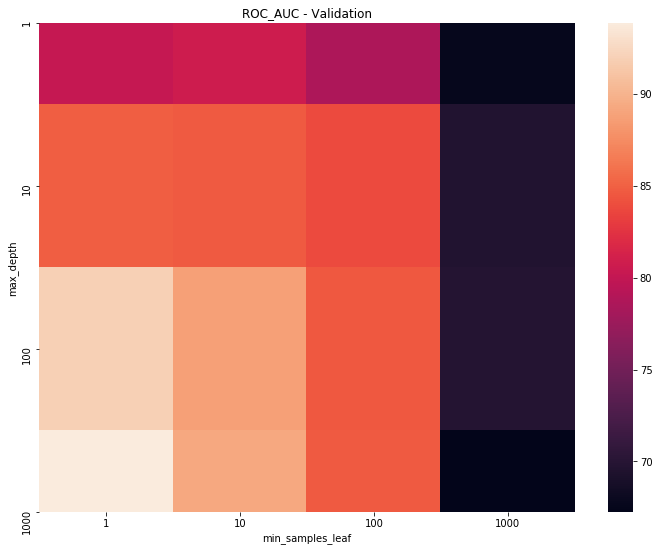

In [68]:
opt_plot(clf)

In [95]:
rand_forr2 = RandomForestClassifier(verbose=1, n_jobs=12)

In [96]:
params = {'max_depth':[500,1000,1500,2000], 'min_samples_leaf':[1,2,3,4,5,6,7,8,9,10]}

In [97]:
clf2 = GridSearchCV(rand_forr2, param_grid=params, cv=kfold, n_jobs=12, verbose=1)

In [98]:
clf2.fit(X_train, y_train.ravel())

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed: 16.9min
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed: 72.5min
[Parallel(n_jobs=12)]: Done 200 out of 200 | elapsed: 77.6min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    6.7s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   18.9s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=12,
                                              

In [99]:
def opt_plot(clf):
    opt = pd.DataFrame(clf.cv_results_)
    cols = [col for col in opt.columns if ('mean' in col or 'std' in col) and 'time' not in col]
    params = pd.DataFrame(list(opt.params))
    opt = pd.concat([params, opt[cols]], axis=1, sort=False)
    plt.figure(figsize=[12,9])
    sns.heatmap(pd.pivot_table(opt,
                               index='max_depth',
                               columns='min_samples_leaf',
                               values='mean_test_score')*100)
    plt.title('ROC_AUC - Validation')

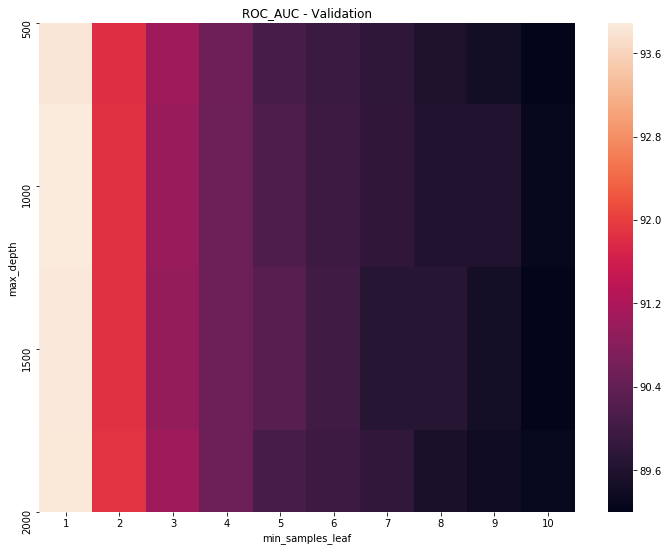

In [101]:
opt_plot(clf2)

In [107]:
opt = pd.DataFrame(clf2.cv_results_)
cols = [col for col in opt.columns if ('mean' in col or 'std' in col or 'rank' in col) and 'time' not in col]
params = pd.DataFrame(list(opt.params))
opt = pd.concat([params, opt[cols]], axis=1)

In [110]:
opt.sort_values(by='rank_test_score', ascending=True).head(10)

,max_depth,min_samples_leaf,mean_test_score,std_test_score,rank_test_score
10,1000,1,0.938930,0.001267,1
20,1500,1,0.938693,0.000713,2
30,2000,1,0.938483,0.001040,3
0,500,1,0.938220,0.000624,4
31,2000,2,0.918897,0.002554,5
21,1500,2,0.918582,0.002181,6
11,1000,2,0.918582,0.001539,7
1,500,2,0.918345,0.002399,8
32,2000,3,0.910563,0.003076,9
2,500,3,0.910405,0.003068,10


There is very little change between the validation scores of the various random forest configuration scores. Since this model will simply act as a baseline model with which to compare the neural network, the highest ranking model from this grid search is chosen.

In [102]:
best_model = clf2.best_estimator_

In [103]:
best_model.score(X_train, y_train)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.3s finished


0.9987118145012882

In [104]:
best_model.score(X_val, y_val)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.1s finished


0.9444050153773361

In [111]:
best_model.score(X_test, y_test)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.1s finished


0.9527357888013626

## 4. Preprocessing with Tensorflow

In [143]:
df2 = pd.read_csv('data/data_cleaned.csv')
df2.drop(columns='Unnamed: 0', inplace=True)

In [144]:
df2.head()

,headline,fake
0,NOT KIDDING! OBAMA Agrees To Turkey’s Demands…...,1
1,"Clinton, in book, says Trump's debate stalking...",0
2,BREAKING NEWS: Susan Rice ADMITS To Unmasking ...,1
3,China's interference in Hong Kong reaching ala...,0
4,WOW! FOX REPORTER GOES OFF On SEIU Thug For Te...,1


In [145]:
X_train, X_test, y_train, y_test = train_test_split(df2['headline'].values, df2['fake'].values, test_size=0.1)

In [146]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1)

In [147]:
tokenizer = Tokenizer(num_words=1500, oov_token='UNK')

In [148]:
tokenizer.fit_on_texts(X_train)

In [149]:
X_train = tokenizer.texts_to_sequences(X_train)

In [150]:
max_length = max([len(x) for x in X_train])
max_length

In [152]:
lengths = [len(x) for x in X_train]

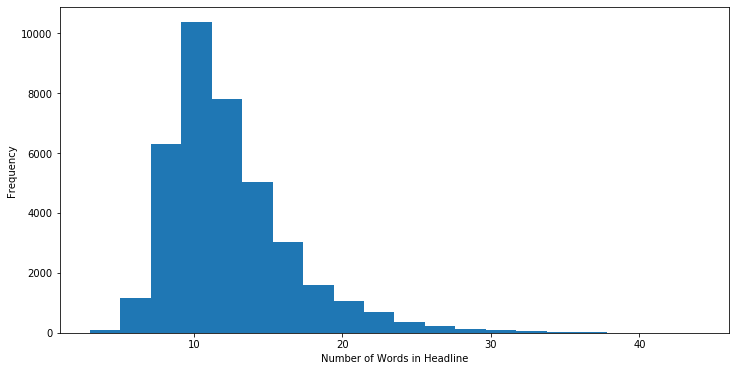

In [283]:
plt.figure(figsize=(12,6))
plt.hist(lengths, bins=20)
plt.xlabel('Number of Words in Headline')
plt.ylabel('Frequency')
plt.show()

In [154]:
X_train = pad_sequences(X_train, padding='post', truncating='post', maxlen=20)

In [155]:
with open('tokenizer_news.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [156]:
X_val = tokenizer.texts_to_sequences(X_val)
X_val = pad_sequences(X_val, padding='post', truncating='post', maxlen=20)

In [157]:
X_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, padding='post', truncating='post', maxlen=20)

## 5. Modelling with Tensorflow/Keras

### 5.1. Dense Neural Network

In [176]:
dnn = Sequential()
dnn.add(Embedding(1500, 32, input_length=20))
dnn.add(GlobalAveragePooling1D())
dnn.add(Dense(32, activation = 'relu'))
dnn.add(Dense(16, activation = 'relu'))
dnn.add(Dense(1, activation = 'sigmoid'))
dnn.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 20, 32)            48000     
_________________________________________________________________
global_average_pooling1d_8 ( (None, 32)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_19 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 17        
Total params: 49,601
Trainable params: 49,601
Non-trainable params: 0
_________________________________________________________________


In [177]:
dnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [178]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                            mode='auto',
                                            restore_best_weights=True)

In [179]:
history = dnn.fit(X_train,
                  y_train,
                  epochs=10,
                  callbacks=[callback], 
                  validation_data=(X_val, y_val))

Train on 38038 samples, validate on 4227 samples
Epoch 1/10
38038/38038 [==============================] - 5s 140us/step - loss: 0.1639 - accuracy: 0.9434 - val_loss: 0.0984 - val_accuracy: 0.9629
Epoch 2/10
38038/38038 [==============================] - 4s 118us/step - loss: 0.0890 - accuracy: 0.9680 - val_loss: 0.0982 - val_accuracy: 0.9659
Epoch 3/10
38038/38038 [==============================] - 5s 119us/step - loss: 0.0822 - accuracy: 0.9700 - val_loss: 0.0990 - val_accuracy: 0.9659


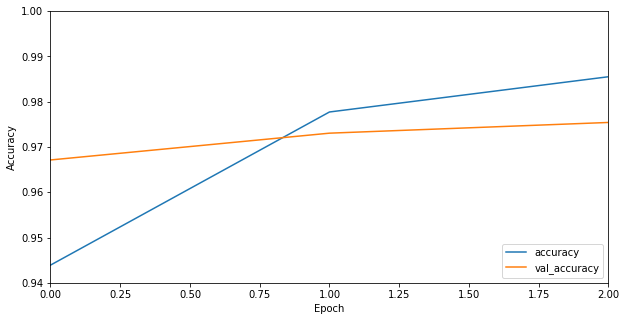

In [285]:
plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.xlim(0,2)
plt.ylim(0.94, 1)
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

In [257]:
val_score = dnn.evaluate(X_val, y_val)

4227/4227 [==============================] - 0s 27us/step


In [258]:
print(f'Model val loss: {round(val_score[0], 3)} \nModel val accuracy: {round(val_score[1]*100, 2)}%')

Model val loss: 0.098 
Model val accuracy: 96.59%


In [259]:
test_score = dnn.evaluate(X_test, y_test)

4697/4697 [==============================] - 0s 27us/step


In [260]:
print(f'Model test loss: {round(test_score[0], 3)} \nModel test accuracy: {round(test_score[1]*100, 2)}%')

Model test loss: 0.111 
Model test accuracy: 96.17%


### 5.2. Convolutional Neural Network

In [230]:
cnn = Sequential()
cnn.add(Embedding(input_dim=1500, output_dim=32, input_length=20))
cnn.add(Conv1D(64, 3, activation='relu', padding='same'))
cnn.add(MaxPooling1D(2))
cnn.add(Conv1D(64, 3, activation='relu', padding='same'))
cnn.add(MaxPooling1D(2))
cnn.add(Conv1D(64, 3, activation='relu', padding='same'))
cnn.add(Flatten())
cnn.add(Dense(1, activation='sigmoid'))
cnn.summary()

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 20, 32)            48000     
_________________________________________________________________
conv1d_26 (Conv1D)           (None, 20, 64)            6208      
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 10, 64)            0         
_________________________________________________________________
conv1d_27 (Conv1D)           (None, 10, 64)            12352     
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 5, 64)             0         
_________________________________________________________________
conv1d_28 (Conv1D)           (None, 5, 64)             12352     
_________________________________________________________________
flatten_4 (Flatten)          (None, 320)             

In [231]:
cnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [232]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                            mode='auto',
                                            restore_best_weights=True)

In [233]:
history = cnn.fit(X_train,
                  y_train,
                  epochs=10,
                  callbacks=[callback], 
                  validation_data=(X_val, y_val))

/Users/ravimalde/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 38038 samples, validate on 4227 samples
Epoch 1/10
38038/38038 [==============================] - 11s 284us/step - loss: 0.1401 - accuracy: 0.9439 - val_loss: 0.0994 - val_accuracy: 0.9671
Epoch 2/10
38038/38038 [==============================] - 9s 247us/step - loss: 0.0640 - accuracy: 0.9777 - val_loss: 0.0800 - val_accuracy: 0.9730
Epoch 3/10
38038/38038 [==============================] - 10s 252us/step - loss: 0.0407 - accuracy: 0.9855 - val_loss: 0.0860 - val_accuracy: 0.9754
Epoch 4/10
38038/38038 [==============================] - 9s 250us/step - loss: 0.0231 - accuracy: 0.9918 - val_loss: 0.1115 - val_accuracy: 0.9716


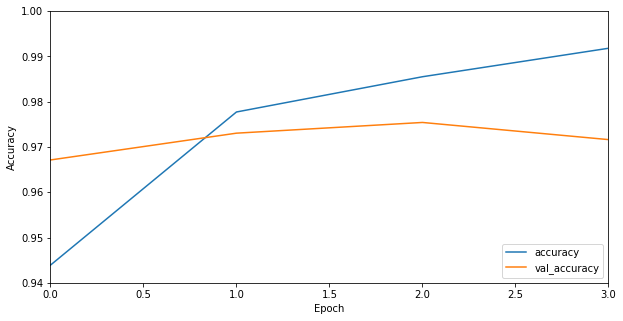

In [284]:
plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.xlim(0,3)
plt.ylim(0.94, 1)
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

In [253]:
val_score = cnn.evaluate(X_val, y_val)

4227/4227 [==============================] - 0s 105us/step


In [254]:
print(f'Model val loss: {round(val_score[0], 3)} \nModel val accuracy: {round(val_score[1]*100, 2)}%')

Model val loss: 0.086 
Model val accuracy: 97.54%


In [255]:
test_score = cnn.evaluate(X_test, y_test)

4697/4697 [==============================] - 0s 98us/step


In [256]:
print(f'Model loss: {round(test_score[0], 3)} \nModel accuracy: {round(test_score[1]*100, 2)}%')

Model loss: 0.092 
Model accuracy: 97.3%


In [287]:
cnn.save("conv_net.h5")

In [263]:
def predict_review(model, sentence):
    sentence = tokenizer.texts_to_sequences([sentence])
    sentence = pad_sequences(sentence, padding='post', truncating='post', maxlen=20)
    prediction = model.predict(sentence)
    probability = prediction[0][0]
    if prediction[0] > 0.5:
        print(f'This news article is FAKE! \n\
              The model is {np.round(probability * 100, 1)}% confident that this is the headline of a fake news article.')
    if prediction[0] < 0.5:
        print(f'This news article is REAL! \n\
              The model is {np.round((1-probability) * 100, 1)}% confident that this is the headline of a real news article.')
        

In [273]:
headline = "blah blah blah"

In [274]:
predict_review(model, headline)

This news article is FAKE! 
The model is 55.3% confident the headline of the article is fake.
